# Batch Normalization Layer test

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline


In [23]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist.train.images.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)

In [37]:
class Neural_Net:
    
    def __init__(self, scope_name, input_dim, output_dim, hidden_dims=[64, 64], use_batchnorm=True):
       
        ##run two model concurrently so we need to define the scope for each name
        with tf.variable_scope(scope_name):
            self.X = tf.placeholder(tf.float32, [None, input_dim], name='X')
            self.y = tf.placeholder(tf.float32, [None, output_dim], name='y')
            self.mode = tf.placeholder(tf.bool, name='train_mode')            
            
            net = self.X
            for i, h_dim in enumerate(hidden_dims):
                with tf.variable_scope('layer{}'.format(i)):
                    net = tf.layers.dense(net, h_dim)
                    
                    ## add another bn layer if use_batchnorm
                    if use_batchnorm:
                        net = tf.layers.batch_normalization(net, training=self.mode)
                        
                    net = tf.nn.relu(net)
            
            # fully connected & output
            net = tf.contrib.layers.flatten(net)
            net = tf.layers.dense(net, output_dim)
            
            self.loss = tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=self.y)
            self.loss = tf.reduce_mean(self.loss, name='loss')    
            
            # When using the batchnormalization layers,
            # it is necessary to manually add the update operations
            # because the moving averages are not included in the graph            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=scope_name)
            with tf.control_dependencies(update_ops):                     
                self.train = tf.train.AdamOptimizer(0.01).minimize(self.loss)
            
            softmax = tf.nn.softmax(net, name='softmax')
            self.accuracy = tf.equal(tf.argmax(softmax, 1), tf.argmax(self.y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.accuracy, tf.float32))

In [38]:
class Solver:

    def __init__(self, sess, model):
        self.model = model
        self.sess = sess
        
    def train(self, X, y):
        
        feed_dict = {
            self.model.X: X,
            self.model.y: y,
            self.model.mode: True
        }
        train = self.model.train
        loss = self.model.loss
        
        return self.sess.run([train, loss], feed_dict=feed_dict)
    
    def evaluate(self, X, y, batch_size=None):
        if batch_size:
            N = X.shape[0]
            
            total_loss = 0
            total_acc = 0
            
            for i in range(0, N, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                
                feed = {
                    self.model.X: X_batch,
                    self.model.y: y_batch,
                    self.model.mode: False
                }
                
                loss = self.model.loss
                accuracy = self.model.accuracy
                
                step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed)
                
                total_loss += step_loss * X_batch.shape[0]
                total_acc += step_acc * X_batch.shape[0]
            
            total_loss /= N
            total_acc /= N
            
            return total_loss, total_acc
            
            
        else:
            feed = {
                self.model.X: X,
                self.model.y: y,
                self.model.mode: False
            }
            
            loss = self.model.loss            
            accuracy = self.model.accuracy

            return self.sess.run([loss, accuracy], feed_dict=feed)

In [39]:
input_dim = 784
output_dim = 10
N = 55000

tf.reset_default_graph()
sess = tf.InteractiveSession()

bn = Neural_Net('batchnorm', input_dim, output_dim, use_batchnorm=True)
nn = Neural_Net('no_norm', input_dim, output_dim, use_batchnorm=False)

bn_solver = Solver(sess, bn)
nn_solver = Solver(sess, nn)

In [40]:
epoch_n = 20
batch_size = 64

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

In [41]:
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(epoch_n):
    for _ in range(N//batch_size):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        
        _, bn_loss = bn_solver.train(X_batch, y_batch)
        _, nn_loss = nn_solver.train(X_batch, y_batch)       
    
    b_loss, b_acc = bn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
    n_loss, n_acc = nn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
    
    # Save train losses/acc
    train_losses.append([b_loss, n_loss])
    train_accs.append([b_acc, n_acc])
    print(f'[Epoch {epoch}-TRAIN] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
    
    b_loss, b_acc = bn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
    n_loss, n_acc = nn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
    
    # Save valid losses/acc
    valid_losses.append([b_loss, n_loss])
    valid_accs.append([b_acc, n_acc])
    print(f'[Epoch {epoch}-VALID] Batchnorm Loss(Acc): {b_loss:.5f}({b_acc:.2%}) vs No Batchnorm Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
    print()

[Epoch 0-TRAIN] Batchnorm Loss(Acc): 0.11049(96.52%) vs No Batchnorm Loss(Acc): 0.18233(94.56%)
[Epoch 0-VALID] Batchnorm Loss(Acc): 0.11935(96.20%) vs No Batchnorm Loss(Acc): 0.19235(94.78%)

[Epoch 1-TRAIN] Batchnorm Loss(Acc): 0.10085(96.78%) vs No Batchnorm Loss(Acc): 0.12586(96.31%)
[Epoch 1-VALID] Batchnorm Loss(Acc): 0.13098(96.22%) vs No Batchnorm Loss(Acc): 0.14783(95.96%)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): 0.06247(97.96%) vs No Batchnorm Loss(Acc): 0.09636(97.08%)
[Epoch 2-VALID] Batchnorm Loss(Acc): 0.10265(97.06%) vs No Batchnorm Loss(Acc): 0.12660(96.46%)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): 0.04329(98.61%) vs No Batchnorm Loss(Acc): 0.11839(96.37%)
[Epoch 3-VALID] Batchnorm Loss(Acc): 0.08780(97.52%) vs No Batchnorm Loss(Acc): 0.14019(95.96%)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): 0.05331(98.21%) vs No Batchnorm Loss(Acc): 0.09259(97.27%)
[Epoch 4-VALID] Batchnorm Loss(Acc): 0.10394(97.18%) vs No Batchnorm Loss(Acc): 0.13323(96.60%)

[Epoch 5-TRAIN] Batchnorm Loss(Acc)

In [36]:
print(bn_solver.evaluate(mnist.test.images, mnist.test.labels))
print(nn_solver.evaluate(mnist.test.images, mnist.test.labels))

[0.10210852, 0.9735]
[0.13313602, 0.9676]


In [31]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]
    
    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)
        
    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

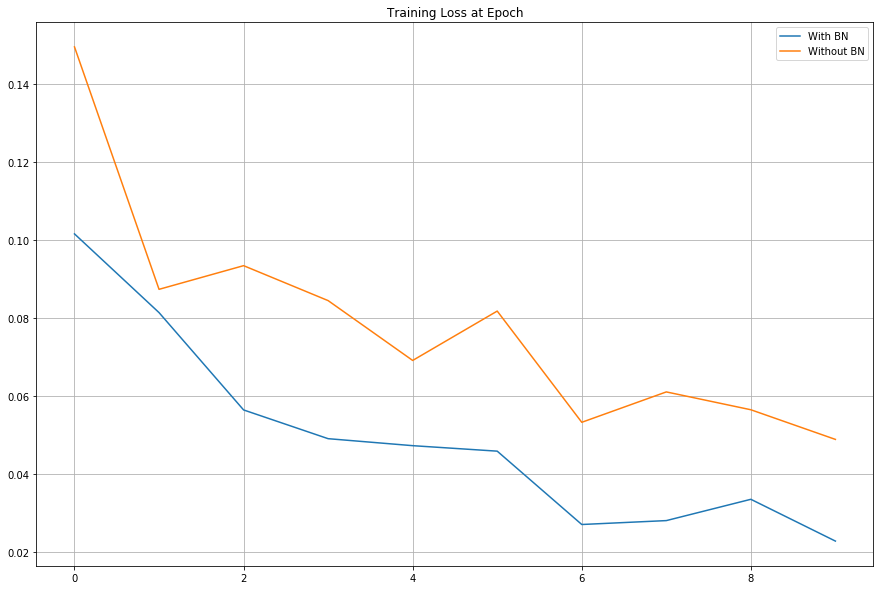

In [32]:
plot_compare(train_losses, title='Training Loss at Epoch')

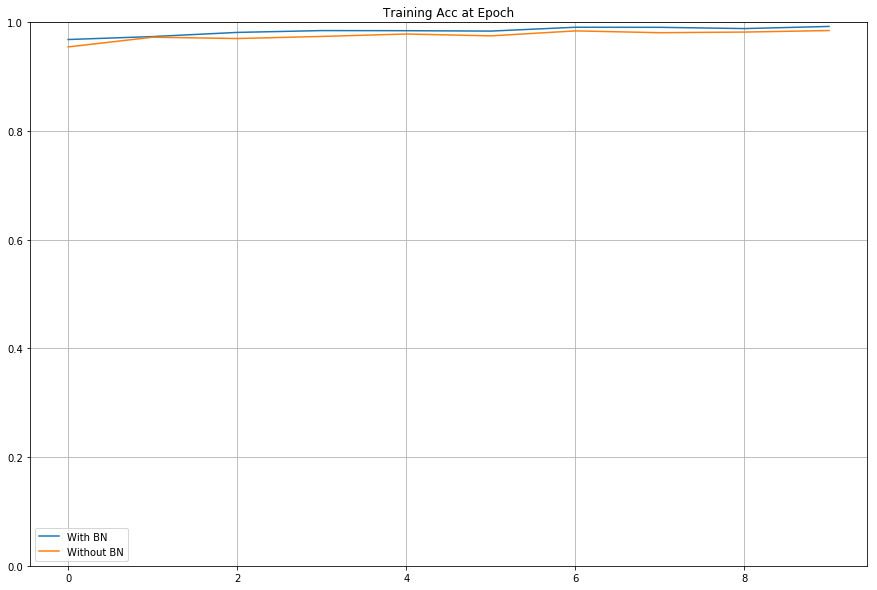

In [33]:
plot_compare(train_accs, [0, 1.0], title="Training Acc at Epoch")

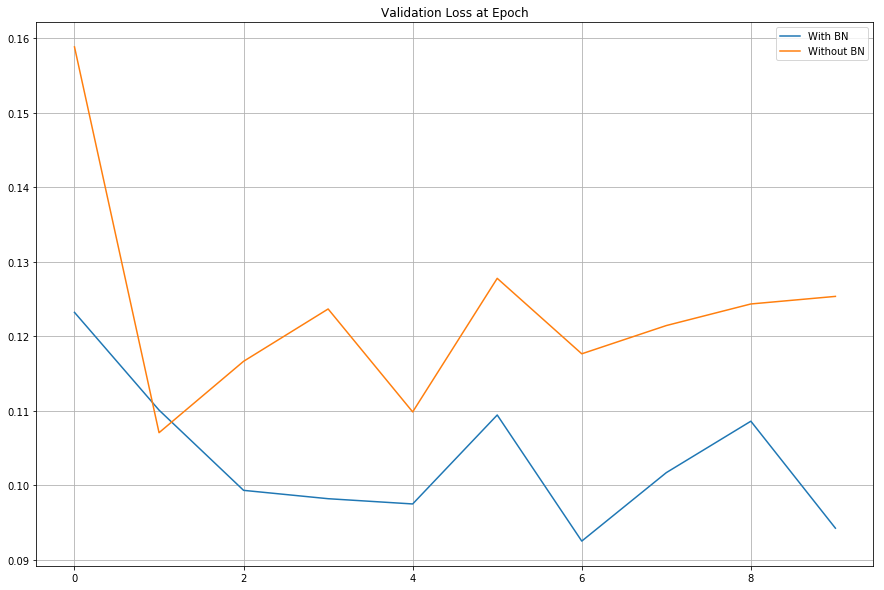

In [34]:
plot_compare(valid_losses, title='Validation Loss at Epoch')

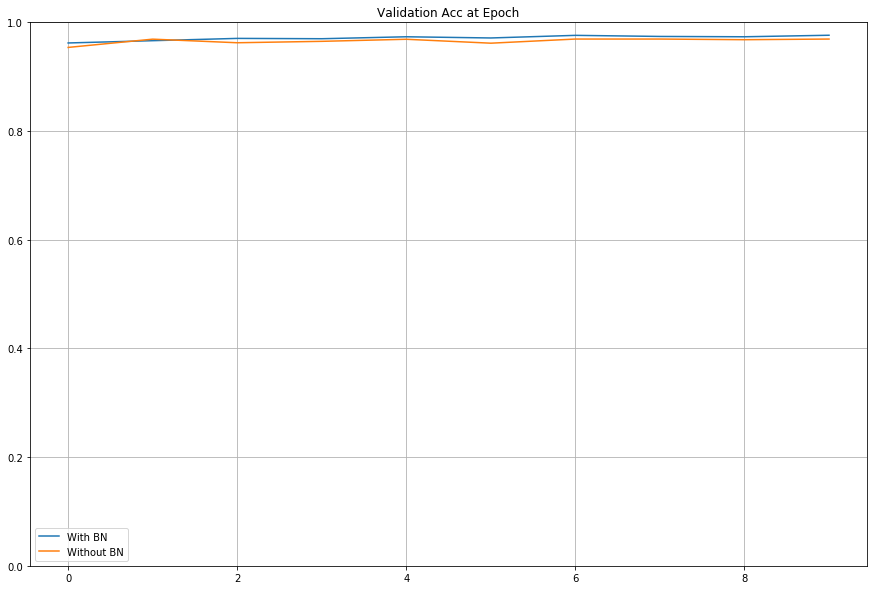

In [35]:
plot_compare(valid_accs, [0, 1.], title='Validation Acc at Epoch')